In [94]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.linear_model import LinearRegression,Ridge,Lasso,SGDRegressor
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.base import clone

## Criando bases de dados para exemplo


In [40]:
m = 100
X = 6 * np.random.rand(m,1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m,1)  # y = 0,5 X^2 + X + 2.0

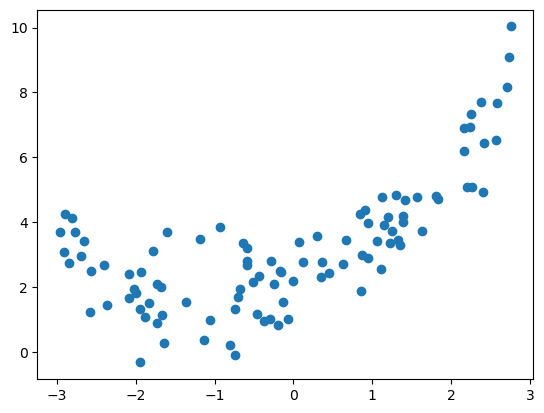

In [42]:
plt.scatter(X,y)

In [44]:
# o polynomial features vai fazer a potenciação da nossa base de dados linear
funcao_polinomial = PolynomialFeatures(degree = 2, include_bias=False)

X_poli = funcao_polinomial.fit_transform(X)

In [46]:
X[0]

array([-1.05164447])

In [48]:
X_poli[0] # valor original e valor ao quadrado

array([-1.05164447,  1.10595609])

## Fazendo a regressão 

In [51]:
reg_lin = LinearRegression()
reg_lin.fit(X_poli, y)
reg_lin.intercept_, reg_lin.coef_

(array([2.12143943]), array([[0.92386881, 0.4455704 ]]))

In [53]:
def plotar_curva_de_aprendizado(modelo, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    
    for m in range(1, len(X_train) + 1):
        modelo.fit(X_train[:m], y_train[:m])
        y_train_predict = modelo.predict(X_train[:m])
        y_val_predict = modelo.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
        
    plt.plot(np.sqrt(train_errors), 'r-+', linewidth=2, label="treino")
    plt.plot(np.sqrt(val_errors), 'b-', linewidth=3, label="validação")
    plt.xlabel("Tamanho do conjunto de treinamento")
    plt.ylabel("Erro Quadrático Médio (RMSE)")
    plt.legend(loc="upper right", fontsize=14)
    plt.show()

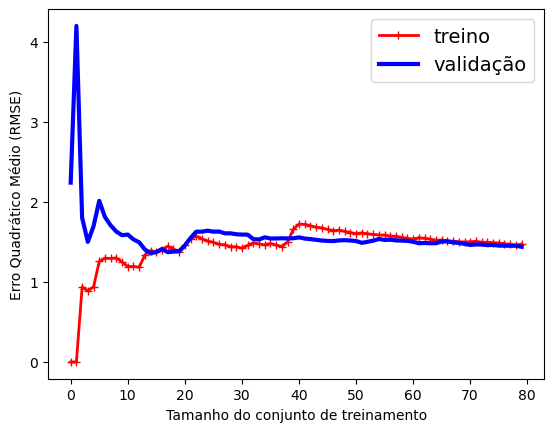

In [55]:
linear_regression = LinearRegression()
plotar_curva_de_aprendizado(linear_regression, X, y)

## EarlyStop


In [132]:
from copy import deepcopy
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
y_train = y_train.ravel()
y_val = y_val.ravel()
poli_scaler = Pipeline([('poli_features', PolynomialFeatures(degree=90,include_bias=False)),
                    ('std_scaler',StandardScaler())])

X_train_poli_escalado = poli_scaler.fit_transform(X_train)
X_val_poli_escalado = poli_scaler.fit_transform(X_val)
"""
max_iter = número de iterações sobre o set de treino ao chamar o fit
tol = tolerancia para parada do gradiente descendente
warm_start = define se o modelo continua treinando apos novas chamadas do metodo fit
penalty = tipo de normalização a ser aplicada, l2(ridge) , l1(lasso), elasticnet(elasticnet l1 + l2) (são tipos de regressões normalizadas)
learning_rate = como vai se comportar a taxa de aprendizado
eta0 = valor da learnin rate
"""
regressor = SGDRegressor(max_iter=1, tol = None, warm_start=True, penalty=None, learning_rate='constant', eta0=0.0005)


valor_erro_minimo = float('inf')
melhor_epoca = None
melhor_modelo = None
erros = []
epocas = []

for epoca in range(1000):
    regressor.fit(X_train_poli_escalado, y_train)
    y_val_predicoes = regressor.predict(X_val_poli_escalado)
    val_erro = mean_squared_error(y_val, y_val_predicoes)
    epocas.append(epoca)
    erros.append(val_erro)
    
    if val_erro < valor_erro_minimo:
        valor_erro_minimo = val_erro
        melhor_epoca = epoca
        melhor_modelo = deepcopy(regressor)

Melhor época: 50
Menor erro de validação (MSE): 1.271224941192525
Erro quadrático médio (MSE) na validação: 1.271224941192525
Erro absoluto médio (MAE) na validação: 1.0020456702178042
Coeficiente de determinação (R^2) na validação: 0.7770848248293473


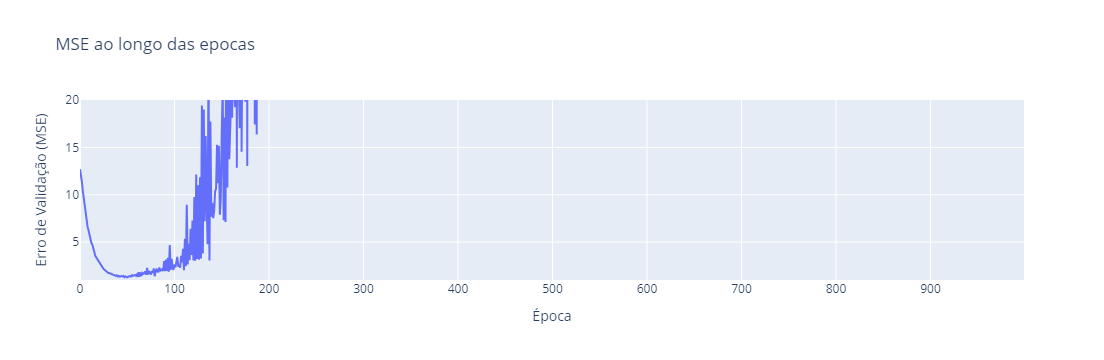

In [142]:
y_val_predicoes = melhor_modelo.predict(X_val_poli_escalado)
mse = mean_squared_error(y_val, y_val_predicoes)
mae = mean_absolute_error(y_val, y_val_predicoes)
r2 = r2_score(y_val, y_val_predicoes)

print(f"Melhor época: {melhor_epoca}")
print(f"Menor erro de validação (MSE): {valor_erro_minimo}")
print(f"Erro quadrático médio (MSE) na validação: {mse}")
print(f"Erro absoluto médio (MAE) na validação: {mae}")
print(f"Coeficiente de determinação (R^2) na validação: {r2}")

import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1000)), y=erros, mode='lines', name='Erro de Validação (MSE)'))
fig.update_layout(title='MSE ao longo das epocas',
                  xaxis_title='Época',
                  yaxis_title='Erro de Validação (MSE)',
                  yaxis_range=[1, 20])  # Definindo o limite do eixo y
fig.show()